In [1]:
import torch
from torch.utils.data import DataLoader
from dataset import YoloDarknetDataset
from torchvision import transforms
import os
import lightnet as ln
from test_script import test_step
from utils import draw_bounding_boxes, mean_average_precision, to_pixel_coords
from lightnet.util import iou_cwh, iou_tlwh

/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TEST_IMG_DIR = "data/data_split/test/images"
TEST_LABEL_DIR =  "data/data_split/test/labels"
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3

print(f"Using Device {DEVICE}")

model = ln.models.YoloV2(NUM_CLASSES)
model.load('models/5_epochs_split.pt', strict=False)
model.to(DEVICE)

loss_fn = ln.network.loss.RegionLoss(
    num_classes= model.num_classes,
    anchors=model.anchors,
    network_stride=model.stride
)

test_transforms = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor()
])

test_dataset = YoloDarknetDataset(
    images_dir=TEST_IMG_DIR,
    labels_dir=TEST_LABEL_DIR,
    classes=["Cyclist", "Pedestrian", "Car"],
    transform=test_transforms,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Using Device cuda


/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/lightnet/network/module/_lightnet.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

In [3]:
do_test = False
if do_test:
    test_step(
        model=model,
        dataloader=test_dataloader,
        loss_fn=loss_fn,
        device=DEVICE
    )

In [4]:
model_2 = ln.models.YoloV2(NUM_CLASSES)
model_2.load('models/5_epochs_split.pt', strict=False)
model_2.to(DEVICE)

YoloV2(
  (backbone): FeatureExtractor(
    selection=[17_convbatch], return=True
    (module): Sequential(
      (1_convbatch): Conv2dBatchAct(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (2_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3_convbatch): Conv2dBatchAct(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (4_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5_convbatch): Conv2dBatchAct(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (6_convbatch): Conv2dBatchAct(128, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), LeakyReLU(negative_slope=0.1, inplace=True))
      (7_convbatch): Conv2dBatchAct(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (8_m

In [5]:
GetBoxes_fn = ln.data.transform.GetAnchorBoxes(
                conf_thresh=0.5,
                network_stride=model.stride,
                anchors=model.anchors
            )

nms_fn = ln.data.transform.NMS(
    iou_thresh=.3,
    class_nms=True
)

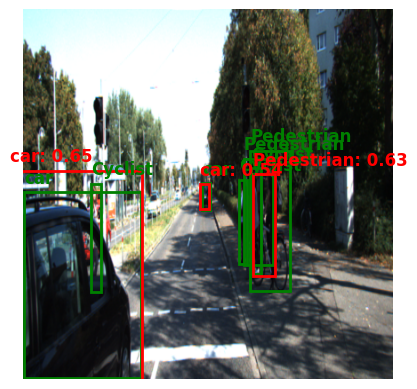

In [6]:
# good indexes: 785, 512, 1023

draw_bounding_boxes(index=1023, 
                    model=model_2, 
                    dataset=test_dataset, 
                    GetBoxes_fn=GetBoxes_fn, 
                    nms_fn=nms_fn, 
                    class_names=["Cyclist", "Pedestrian", "car"], 
                    device=DEVICE)

In [7]:
image, label = test_dataset[1023]
model_input = image.unsqueeze(0).to(DEVICE)
model_2.to(DEVICE)
model_2.eval()

with torch.inference_mode():
    model_output = model_2(model_input)

box_tensor = GetBoxes_fn(model_output.cpu())
output_boxes = nms_fn(box_tensor)


In [ ]:
# pred_boxes (list): list of lists containing all bboxes with each bboxes
# specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
label_boxes = []
for box in label["boxes"]:
    if box[0] != -1: #supress the padding
        x1, y1, x2, y2 = to_pixel_coords(box[1:], 416, 416)
        # add image index on the list
        pred_box = [0, box[0].item(), 1, x1.item(), y1.item(), x2.item(), y2.item()] 
        label_boxes.append(pred_box)


In [9]:
label_boxes

[[0,
  2.0,
  1,
  200.64129638671875,
  194.94314575195312,
  9.170761108398438,
  29.863235473632812],
 [0, 2.0, 1, 0.0, 205.03805541992188, 132.02809143066406, 209.85260009765625],
 [0,
  1.0,
  1,
  254.5806121826172,
  158.36843872070312,
  45.03651428222656,
  158.03561401367188],
 [0,
  0.0,
  1,
  255.6725311279297,
  178.513916015625,
  11.143569946289062,
  118.9981689453125],
 [0,
  0.0,
  1,
  242.06040954589844,
  191.06048583984375,
  9.418624877929688,
  94.90347290039062],
 [0,
  0.0,
  1,
  75.92167663574219,
  195.5089111328125,
  11.381385803222656,
  121.63839721679688],
 [0,
  1.0,
  1,
  247.58029174804688,
  167.55369567871094,
  33.280029296875,
  119.80799865722656]]

In [10]:
# pred_boxes (list): list of lists containing all bboxes with each bboxes
# specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
pred_boxes = []
for bbox in output_boxes:
    x, y, h, w = to_pixel_coords(bbox[1:5], 1, 1)
    pred_boxes.append(
        [bbox[0].item(), 
         bbox[6].item(), 
         bbox[5].item() , 
         x.item(), 
         y.item(),
         h.item(), 
         w.item()])

In [11]:
pred_boxes

[[0.0,
  2.0,
  0.6544097661972046,
  -15.551605224609375,
  180.86196899414062,
  148.5510711669922,
  259.0655517578125],
 [0.0,
  1.0,
  0.6278639435768127,
  257.5738525390625,
  184.99307250976562,
  25.24951171875,
  114.72711181640625],
 [0.0,
  2.0,
  0.5401148796081543,
  198.7346954345703,
  196.47166442871094,
  9.578216552734375,
  27.611419677734375]]

In [12]:
mean_average_precision(pred_boxes, label_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=3)

(tensor(0.3333), [tensor(0.), tensor(0.), tensor(1.0000)])